In [ ]:
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from time import time
from tqdm import tqdm

import numpy as np

import warnings

from scipy import linalg

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

In [2]:
class FrechetInceptionDistance:

    def __init__(self, verbose=False) -> None:
        self.verbose = verbose

    def compute_fid(self, real_activations, fake_activations):
        real_activations = real_activations.cpu().numpy()
        fake_activations = fake_activations.cpu().numpy()
        
        real_mu = np.mean(real_activations, axis=0)
        real_sigma = np.cov(real_activations, rowvar=False)
        
        fake_mu = np.mean(fake_activations, axis=0)
        fake_sigma = np.cov(fake_activations, rowvar=False)
        fid = self.calculate_frechet_distance(fake_mu, fake_sigma, real_mu, real_sigma)
        return fid

    @staticmethod
    def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
        """
        https://github.com/bioinf-jku/TTUR/blob/master/FIDvsINC/fid.py#L99-L148
        Numpy implementation of the Frechet Distance.
        The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
        and X_2 ~ N(mu_2, C_2) is
                d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
        Stable version by Dougal J. Sutherland.
        Params:
        -- mu1 : Numpy array containing the activations of the pool_3 layer of the
                 inception net ( like returned by the function 'get_predictions')
                 for generated samples.
        -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
                   on an representive data set.
        -- sigma1: The covariance matrix over activations of the pool_3 layer for
                   generated samples.
        -- sigma2: The covariance matrix over activations of the pool_3 layer,
                   precalcualted on an representive data set.
        Returns:
        --   : The Frechet Distance.
        """

        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(mu2)

        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)

        assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
        assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

        diff = mu1 - mu2

        # product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
            warnings.warn(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

        # numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError("Imaginary component {}".format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

### ARN MODEL

In [3]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test(net,img_size=32):
    def unpack(x):
        if isinstance(x,tuple):
            return [unpack(y) for y in x]
        else:
            return list(x.size())
        
    x = torch.randn(1,1,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {}".format(unpack(x), unpack(y), count_parameters(net)))

In [5]:
class Generator(nn.Module):
    def __init__(self, ndf = 64, ngf= 64, nc = 1, input_dim = 28, z_dim=32):
        super(Generator, self).__init__()

        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, track_running_stats = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, track_running_stats = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8, track_running_stats = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4, track_running_stats = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2, track_running_stats = False),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False)
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, self.z_dim)
        self.fc22 = nn.Linear(512, self.z_dim)

        self.fc3 = nn.Linear(self.z_dim, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc21(h), self.fc22(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        conv = self.encoder(x);
        h = self.fc1(conv.view(-1, 1024))
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.relu(self.fc3(z))
        deconv_input = self.fc4(h)
        
        deconv_input = deconv_input.view(-1,1024,1,1)
        
        return self.decoder(deconv_input)

    def forward(self, x, t=1):
        z, mu, logvar = self.encode(x)

        logits = self.decode(z)
        
        sample = self.sample_bernoulli(logits,t)

        return logits, mu, logvar, sample
    

    def sample_bernoulli(self, logits, t):
        return gumbel_sigmoid(logits, t)

In [6]:
m = Generator()


test(m,28)

Input: [1, 1, 28, 28]; Output: [[1, 1, 28, 28], [1, 32], [1, 32], [1, 1, 28, 28]]; N. of params: 15818304


In [7]:
class Discriminator(nn.Module):

    def __init__(self, ndf = 64, ngf= 64, nc = 1, input_dim = 28):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, track_running_stats = False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, track_running_stats = False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.ReLU(inplace=True)
        )

        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.LayerNorm(512),
            
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.LayerNorm(256),
            
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.LayerNorm(128),
            
            nn.Linear(128, 1)
        )

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  

    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,1024)
        x = self.classifier(x)
        x = x.squeeze(1)
        return self.sigmoid(x)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [8]:
m = Discriminator()

test(m,28)

Input: [1, 1, 28, 28]; Output: [1]; N. of params: 5313025


In [9]:
def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)

In [10]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        
    def forward(self, true_preds, fake_preds, step):
        
        bs = true_preds.size(0)

        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(device)
    
        D_real_loss = self.criterion(true_preds, y_real)
        
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(device)

        D_fake_loss = self.criterion(fake_preds, y_fake)

        return D_real_loss + D_fake_loss

In [11]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        self.bern_crit = torch.nn.BCEWithLogitsLoss()
        

    def KLD(self,z_mean, z_logvar):
        return torch.mean(0.5 * (-0.5 * z_logvar + torch.exp(0.5 * z_logvar) + z_mean ** 2))
        

    def log_bernoulli_pdf(self, data, logits):
        targets = data.flatten()
        logprobs = logits.flatten()

        return -torch.mean((F.logsigmoid(logprobs)) - (1 - targets) * logprobs)

    
    def forward(self, true_data, fake_preds, logits, z_mean, z_logvar, beta = 1, gamma = 1e-2):
        
        bs = fake_preds.size(0)
                
        y_fake = torch.ones(bs).to(device)
        log_p_y = self.criterion(fake_preds, y_fake)
        
        kld = self.KLD(z_mean, z_logvar)
        log_p_data = self.log_bernoulli_pdf(true_data, logits)

        return gamma*log_p_y + log_p_data + beta*kld, log_p_y, log_p_data, kld


# Trainer

In [12]:
class AADNet(nn.Module):
    def __init__(self, device, vae_model):
        super(AADNet, self).__init__()
        self.device = device

        self.D = Discriminator().to(self.device)
        self.G = Generator().to(self.device)
        
        self.vae_model = vae_model

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=1e-4)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=1e-4)
        
        self.d_loss_criterion = DiscriminatorLoss()
        self.g_loss_criterion = GeneratorLoss()
        
        self.fid = FrechetInceptionDistance(verbose=True)
        
        self.temperature = 1
        self.anneal = 0.9995
        
        
        
    def D_step(self,true_data, step):
        self.D.zero_grad()

        _, _, _, sampled_data = self.G(true_data, self.temperature)
        
        true_pred = self.D(true_data)
        fake_pred = self.D(sampled_data.detach())

        d_loss_batch = self.d_loss_criterion(true_pred, fake_pred, step)
        d_loss_batch.backward()
        self.d_optimizer.step()

        return d_loss_batch, true_pred, fake_pred

    
    def G_step(self,true_data, step):
        self.G.zero_grad()
        
        logits, z_mean, z_logvar, sampled_data = self.G(true_data, self.temperature)
        noise_pred = self.D(sampled_data)

        gen_loss_batch, a, b, c = self.g_loss_criterion(true_data, noise_pred, logits, z_mean, z_logvar, self.temperature)
        gen_loss_batch.backward()

        self.g_optimizer.step()

        return logits, sampled_data, gen_loss_batch, a, b, c

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
            
    def acc_fid(self, test_loader):
        self.D.eval()
        self.G.eval()
       
        fid_score = []
        accuracy = []
        
        for batch, _ in test_loader:
            batch = batch.to(self.device)
            batch = (batch > thresh).float()
            
            with torch.no_grad():
                _, _, _, fake_data = self.G(batch)
                
                y_real_pred = self.D(batch)
                y_fake_pred = self.D(fake_data)
            
            y = torch.cat((torch.ones(batch.shape[0]), torch.zeros(batch.shape[0])))
            
            y_real_pred = (y_real_pred > .5).int()
            y_fake_pred = (y_fake_pred > .5).int()
            
            
            y_pred = torch.cat((y_real_pred.cpu(), y_fake_pred.cpu()))
            _acc = accuracy_score(y, y_pred)
            
            batch = batch.reshape(-1, 28*28) 
            fake_data = fake_data.reshape(-1, 28*28) 
            f, _ = self.vae_model.encode(batch)
            f_tilde, _ = self.vae_model.encode(fake_data)
            _fid = self.fid.compute_fid(f.detach(), f_tilde.detach())
            
            accuracy.append(_acc)
            fid_score.append(_fid)
            
        return np.mean(accuracy), np.mean(fid_score)
                        
    
    def train(self, data_loader, test_loader, batch_size = 32, num_epochs = 10, step = 10, thresh = 0., lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        d_losses = np.zeros(num_epochs)
        g_losses = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        logpyes = np.zeros(num_epochs)
        logpdes = np.zeros(num_epochs)
        kldes = np.zeros(num_epochs)
        
        fid_scores = np.zeros(num_epochs)
        accuracies = np.zeros(num_epochs)
        
        fid_scores_tr = np.zeros(num_epochs)
        accuracies_tr = np.zeros(num_epochs)
        
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                i = 0
                self.D.train()
                self.G.train()
                for batch, _ in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)
                    batch = (batch > thresh).float()

                    ### Train discriminator ###
                    for _ in range(num_q_steps):
                        d_loss, real_score, fake_score = self.D_step(batch,step_count)

                    ### Train Generator ###
                    for _ in range(num_g_steps):
                        logits, sampled_data, g_loss, a, b, c = self.G_step(batch,step_count)
                        
                    y = torch.cat((torch.ones(batch.shape[0]), torch.zeros(batch.shape[0])))
            
                    y_real_pred = (real_score > .5).int()
                    y_fake_pred = (fake_score > .5).int()
            
            
                    y_pred = torch.cat((y_real_pred.cpu(), y_fake_pred.cpu()))
                    _acc_tr = accuracy_score(y, y_pred)
            
                    batch = batch.reshape(-1, 28*28) 
                    sampled_data = sampled_data.reshape(-1, 28*28) 
                    f, _ = self.vae_model.encode(batch)
                    f_tilde, _ = self.vae_model.encode(sampled_data)
                    _fid_tr = self.fid.compute_fid(f.detach(), f_tilde.detach())
                    
                    d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
                    g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
                    logpyes[epoch] = logpyes[epoch]*(i/(i+1.)) + b.item()*(1./(i+1.)) 
                    logpdes[epoch] = logpdes[epoch]*(i/(i+1.)) + a.item()*(1./(i+1.)) 
                    kldes[epoch] = kldes[epoch]*(i/(i+1.)) + c.item()*(1./(i+1.))
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

                    fid_scores_tr[epoch] = fid_scores_tr[epoch]*(i/(i+1.)) + _fid_tr*(1./(i+1.))
                    accuracies_tr[epoch] = accuracies_tr[epoch]*(i/(i+1.)) + _acc_tr*(1./(i+1.))
                    
                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                        
                    i += 1
                accuracy, fid_score = self.acc_fid(test_loader)
                
                fid_scores[epoch] = fid_score
                accuracies[epoch] = accuracy
                
                sys.stdout.write("\r" + 'Epoch [{:>3}/{}]| d_loss: {:.4f} | g_loss: {:.4f} ({:.2f}, {:.2f}, {:.2f}) | D(x): {:.2f} | D(G(x)): {:.2f} | FID Train: {:.3f} | ACC Train: {:.2f} | FID Test: {:.3f} | ACC Test: {:.2f}'
                              .format(epoch+1, num_epochs, d_losses[epoch], g_losses[epoch], logpdes[epoch], logpyes[epoch], kldes[epoch], real_scores[epoch], fake_scores[epoch], fid_scores_tr[epoch], accuracies_tr[epoch], fid_scores[epoch], accuracies[epoch]))
                sys.stdout.flush()
                
                
                
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        
        return [d_losses[:epoch], g_losses[:epoch], logpyes[:epoch], logpdes[:epoch], kldes[:epoch], real_scores[:epoch], fake_scores[:epoch], fid_scores_tr[:epoch], accuracies_tr[:epoch], fid_scores[:epoch], accuracies[:epoch]]
       

In [13]:
print("[INFO] loading dataset...")

batch_size = 256
epochs = 100
rowcol = 784

transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

thresh = 0.3

[INFO] loading dataset...


### Model VAE

In [14]:
class VAE(nn.Module):
    def __init__(self, p_dims, q_dims=None, ):
        super(VAE, self).__init__()

        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        
        self.init_weights()        
        

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            nn.init.xavier_normal_(layer.weight)

        for layer in self.p_layers:
            nn.init.xavier_normal_(layer.weight)
        
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar
    
    
    def encode(self, input):
        h = input
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.relu(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps.mul(std).add_(mu)


    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.relu(h)

        return torch.sigmoid(h)

    
    def generate(self,n_samples=1):
        
        device = next(self.parameters()).device
        
        with torch.no_grad():
            z = torch.randn((n_samples,self.p_dims[0])).to(device)
            return self.decode(z)

In [15]:
vae_model = VAE(p_dims=[128,256,784]).to(device)

In [16]:
vae_model.load_state_dict(torch.load('VAE_128.ckpt', map_location=torch.device(device)))

<All keys matched successfully>

# MAIN

In [17]:
model = AADNet(device, vae_model)

In [18]:
res = model.train(train_loader, test_loader, batch_size = batch_size, num_epochs = epochs, thresh=thresh)
[d_losses, g_losses, logpyes, logpdes, kldes, real_scores, fake_scores, fid_scores_tr, accuracies_tr, fid_scores, accuracies] = res 

[INFO] Starting training phase...
Epoch [100/100]| d_loss: 0.0001 | g_loss: 0.1861 (10.06, 0.09, 13.33) | D(x): 1.00 | D(G(x)): 0.00 | FID Train: 0.871 | ACC Train: 1.00 | FID Test: 1.188 | ACC Test: 1.00
[INFO] Training phase... Elapsed time: 8200 seconds



In [23]:
import pandas as pd
df_losses = pd.DataFrame(d_losses, columns=['LD'])
df_losses['LG'] = g_losses
df_losses['BCE'] = logpdes
df_losses['MSE'] = logpyes
df_losses['KL'] = kldes
df_losses['FakeScores'] = fake_scores
df_losses['RealScores'] = real_scores
df_losses['FID TRAIN'] = fid_scores_tr
df_losses['ACCURACIES TRAIN'] = accuracies_tr
df_losses['FID TEST'] = fid_scores
df_losses['ACCURACIES TEST'] = accuracies


df_losses

,LD,LG,BCE,MSE,KL,FakeScores,RealScores,FID TRAIN,ACCURACIES TRAIN,FID TEST,ACCURACIES TEST
0,1.292573,0.820655,1.044326,0.337064,0.501416,0.355449,0.645243,14.553608,0.973396,10.214302,1.000000
1,1.242486,0.709738,1.160421,0.273115,0.506567,0.313783,0.686336,9.343580,0.999875,10.327925,1.000000
2,1.193806,0.658236,1.256692,0.266101,0.508807,0.284933,0.715266,9.434109,0.999792,10.192142,1.000000
3,1.140193,0.615280,1.357120,0.262912,0.510789,0.257751,0.741831,9.444545,0.999958,9.882489,1.000000
4,1.083595,0.577326,1.458748,0.260452,0.512585,0.232776,0.767166,9.341637,1.000000,9.833320,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
94,0.000482,0.172060,9.834395,0.073584,8.766614,0.000106,0.999943,0.574166,0.999967,0.920976,1.000000
95,0.000405,0.170729,9.877815,0.071827,9.237802,0.000068,0.999924,0.540582,0.999975,0.990721,0.994971
96,0.000487,0.188210,9.860139,0.089483,10.584536,0.000070,0.999925,0.940882,0.999975,0.800788,0.999756
97,0.000126,0.180769,9.935098,0.081298,11.322066,0.000055,0.999962,0.737809,1.000000,1.085254,0.999219


In [27]:
df_losses.to_csv('DF_Losses_FID.csv', index=False)

In [28]:
torch.save(model.G.state_dict(), './ARN_G_MNIST_FID.ckpt')
torch.save(model.D.state_dict(), './ARN_D_MNIST_FID.ckpt')

Text(0.5, 0, 'Epochs')

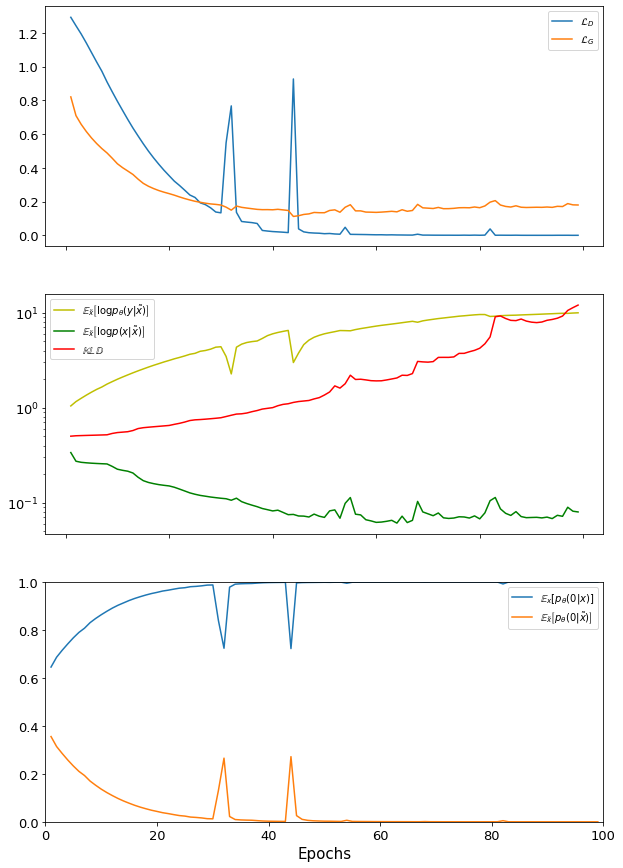

In [24]:
import matplotlib

matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

num_epochs = len(d_losses)

fig, ax = plt.subplots(3, 1, figsize = (10, 15))

plt.xlim(0, num_epochs + 1)
plt.yticks(fontsize=13)
ax[0].plot(range(1, num_epochs + 1), d_losses[:num_epochs], label='$\mathcal{L}_{D}$')
ax[0].plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='$\mathcal{L}_{G}$')   
ax[0].legend()

plt.xlim(0, num_epochs + 1)
   
ax[1].plot(range(1, num_epochs + 1), logpdes[:num_epochs], 'y', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p_{\theta} (y|\tilde{x})\right]$')    
ax[1].plot(range(1, num_epochs + 1), logpyes[:num_epochs], 'green', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p(x|\tilde{x})\right]$') 
ax[1].plot(range(1, num_epochs + 1), kldes[:num_epochs], 'red', label=r'$\mathbb{KLD}$') 
ax[1].set_yscale('log')
ax[1].legend()


plt.xlim(0, num_epochs + 1)
plt.ylim(0, 1)
ax[2].plot(range(1, num_epochs + 1), real_scores[:num_epochs], label=r'$\mathbb{E}_{x}\left[p_{\theta} (0|x)\right]$')  
ax[2].plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label=r'$\mathbb{E}_{\tilde{x}}\left[p_{\theta} (0|\tilde{x})\right]$')
ax[2].legend()

for ax in ax.flat:
    ax.label_outer()
    
plt.xlabel('Epochs', fontsize=15)

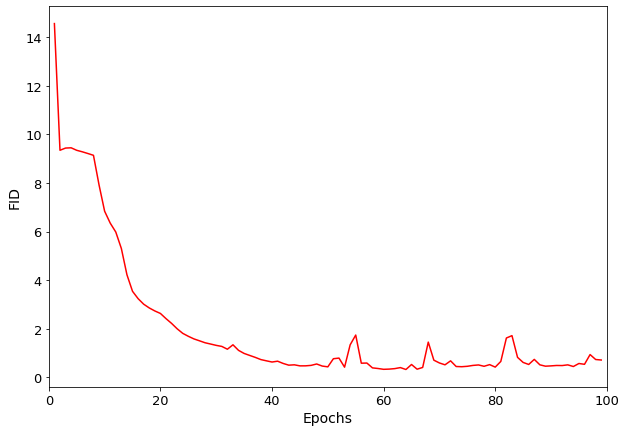

In [35]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.xlim(0, num_epochs + 1)
# make a plot
ax.plot(range(1, num_epochs + 1), fid_scores_tr[:num_epochs], color = 'red')
# set x-axis label
ax.set_xlabel('Epochs', fontsize=14)
# set y-axis label
ax.set_ylabel('FID', fontsize=14)

plt.savefig('FID.pdf')